In [1]:
import yfinance as yf
from datetime import datetime, timedelta
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

# from sklearn.tree import DecisionTreeRegressor
# from xgboost import XGBRegressor

# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.arima_model import ARIMA

In [2]:
tickerSymbol = 'SI=F'
series = yf.Ticker(tickerSymbol)

In [3]:
prices_full = series.history(start='2024-01-01', end='2024-07-31')
print(prices_full.iloc[-1])

Open               27.990000
High               28.219999
Low                27.750000
Close              27.959999
Volume          56653.000000
Dividends           0.000000
Stock Splits        0.000000
Name: 2024-07-26 00:00:00-04:00, dtype: float64


In [4]:
prices = series.history(start='2024-01-01', end='2024-07-31').Open
returns = prices.pct_change().dropna()

In [5]:
print(prices)

Date
2024-01-02 00:00:00-05:00    23.844999
2024-01-03 00:00:00-05:00    23.264999
2024-01-04 00:00:00-05:00    22.930000
2024-01-05 00:00:00-05:00    23.065001
2024-01-08 00:00:00-05:00    22.990000
                               ...    
2024-07-22 00:00:00-04:00    29.170000
2024-07-23 00:00:00-04:00    29.000000
2024-07-24 00:00:00-04:00    29.115999
2024-07-25 00:00:00-04:00    28.700001
2024-07-26 00:00:00-04:00    27.990000
Name: Open, Length: 143, dtype: float64


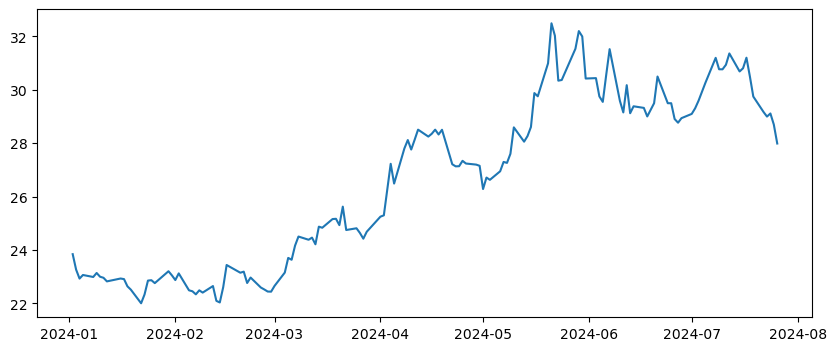

In [6]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.show()

In [7]:
baseline_profit = prices.iloc[-1] - prices.iloc[0]
baseline_profit = np.round(baseline_profit,2)
print("Baseline Profit:  $" + str(baseline_profit) + " per contract")

Baseline Profit:  $4.15 per contract


In [8]:
print(str(100) + "/" + str(prices.iloc[0]) + " = " + "x/$" + str(baseline_profit))

100/23.844999313354492 = x/$4.15


In [9]:
print("Profit to beat:  $17.38")

Profit to beat:  $17.38


In [10]:
window_size = 5

data_train = prices[:'2024-06-30'].to_numpy()
data_test = prices['2024-06-24':].to_numpy()

X_train = []
y_train = []
for i in range(len(data_train) - window_size):
    X_train.append(data_train[i: i + window_size])
    y_train.append(data_train[i+window_size])

X_test = []
y_test = []
for i in range(len(data_test) - window_size):
    X_test.append(data_test[i: i + window_size])
    y_test.append(data_test[i+window_size])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [23]:
baseline_profit_test = data_test[-1] - data_test[0]
baseline_profit_test = np.round(baseline_profit_test,2)
print("Baseline Profit (Test):  $" + str(baseline_profit_test) + " per contract")

Baseline Profit (Test):  $-1.51 per contract


In [11]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [12]:
print('X_train shape = ', X_train.shape)
print('y_train shape = ', y_train.shape,'\n')

print('X_test shape = ', X_test.shape)
print('y_test shape = ', y_test.shape)

X_train shape =  (119, 5, 1)
y_train shape =  (119,) 

X_test shape =  (19, 5, 1)
y_test shape =  (19,)


In [13]:
model = Sequential()
model.add(SimpleRNN(128, activation='relu', return_sequences=True, input_shape=(window_size, 1)))
model.add(SimpleRNN(64, activation='relu'))
model.add(Dense(1))

In [14]:
model.compile(loss='mse', optimizer='adam')
model.fit(np.array(X_train), np.array(y_train), epochs=500, verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 3ms/step - loss: 638.9007
Epoch 2/500
4/4 [==============================] - 0s 2ms/step - loss: 84.6725
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 25.3316
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 20.8593
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 6.2450
Epoch 6/500
4/4 [==============================] - 0s 2ms/step - loss: 7.4877
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 1.5346
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 3.0691
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.7304
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 1.4517
Epoch 11/500
4/4 [==============================] - 0s 2ms/step - loss: 0.8339
Epoch 12/500
4/4 [==============================] - 0s 2ms/step - loss: 0.7329
Epoch 13/500
4/4 [==============================] - 0s 2

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5, 128)            16640     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 29057 (113.50 KB)
Trainable params: 29057 (113.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
results = model.predict(np.array(X_test))

1/1 [==============================] - 0s 159ms/step


In [17]:
pred_series = pd.Series(results.flatten(), index=prices['2024-06-24':].index[window_size:window_size + len(results)])

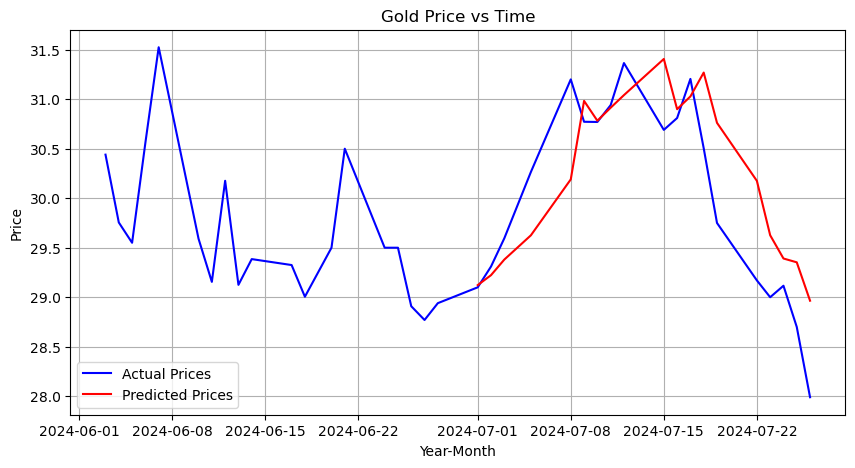

In [18]:
prices_2024 = prices['2024-06-01':]
plt.figure(figsize=(10, 5))
plt.plot(prices_2024, color='blue', label='Actual Prices')
plt.plot(pred_series, color='red', label='Predicted Prices')
plt.legend()
plt.xlabel('Year-Month')
plt.ylabel('Price')
plt.title('Gold Price vs Time')
plt.grid(True)
plt.show()

In [19]:
trading_period = data_test
print(trading_period)
predictions = results

[29.5        29.5        28.9090004  28.77000046 28.94000053 29.10000038
 29.30999947 29.59499931 30.26499939 31.20000076 30.77199936 30.77000046
 30.94000053 31.36499977 30.69000053 30.80999947 31.20499992 30.50499916
 29.75       29.17000008 29.         29.11599922 28.70000076 27.98999977]


Day 1: 
 Daily Open = 29.5,  
 Daily Close = 29.5,  
 Cash = 100.0, 
 Shares = 3.389830508474576, 
 Prediction = [29.12218], 
 Daily Revenue = 0.0, 

Day 2: 
 Daily Open = 29.5,  
 Daily Close = 28.909000396728516,  
 Cash = 97.99661151433395, 
 Shares = 3.389830508474576, 
 Prediction = [29.222715], 
 Daily Revenue = -2.0033884856660507, 

Day 3: 
 Daily Open = 28.909000396728516,  
 Daily Close = 28.770000457763672,  
 Cash = 99.5191810956543, 
 Shares = 3.4591303271529408, 
 Prediction = [29.380222], 
 Daily Revenue = -0.4808189043456963, 

Day 4: 
 Daily Open = 28.770000457763672,  
 Daily Close = 28.940000534057617,  
 Cash = 100.59089354740719, 
 Shares = 3.475842836596643, 
 Prediction = [29.625301], 
 Daily Revenue = 0.590893547407191, 

Day 5: 
 Daily Open = 28.940000534057617,  
 Daily Close = 29.100000381469727,  
 Cash = 100.55286746530574, 
 Shares = 3.4554249535108497, 
 Prediction = [30.1903], 
 Daily Revenue = 0.5528674653057379, 

Day 6: 
 Daily Open = 29.1000003814697

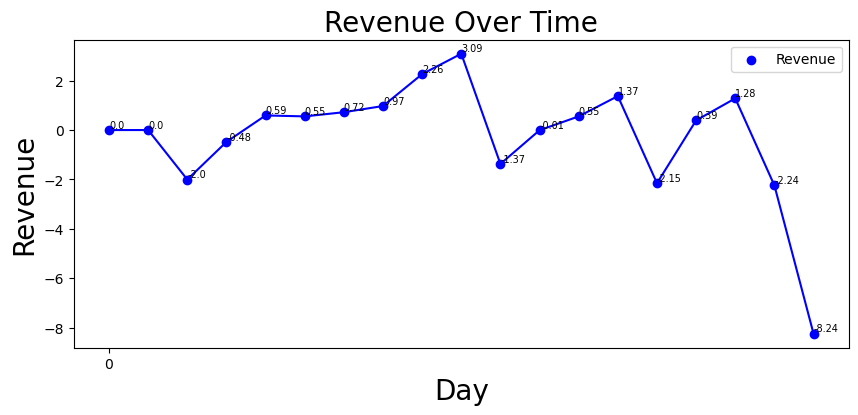

Cash Used:  1800


-4.71214581835757

In [20]:
def BuySellModelPredict(starting_cash):
    prices = trading_period
    revenue = np.zeros(len(predictions))
    cash = starting_cash
    cash_used = 0
    shares = 0
    holding = False

    for i in range (1, len(predictions)):
        if predictions[i-1] > 0:
            shares = starting_cash / prices[i-1]
            cash = shares * prices[i]
            cash_used += starting_cash
            revenue[i] = cash - starting_cash
            holding = True

        print(f"Day {i}: \n Daily Open = {prices[i-1]},  \n Daily Close = {prices[i]},  \n Cash = {cash}, \n Shares = {shares}, \n Prediction = {predictions[i-1]}, \n Daily Revenue = {revenue[i]}, \n")

    if holding:
        cash = shares * prices[-1]
        revenue[-1] = cash - starting_cash
        print(f"Day {i+1}: Forced Sell: Close = {prices[-1]}, Cash = {cash}, Revenue = {revenue[-1]}")

    #   plt.figure(figsize=(10, 4))
    #   plt.plot(revenue)
    #   plt.ylabel('Revenue', fontsize=20)
    #   plt.xlabel('Hour', fontsize=20)
    #   plt.title('Revenue Over Time', fontsize=20)
    #   plt.show()

    plt.figure(figsize=(10, 4))
    days = range(len(revenue))
    plt.scatter(days, revenue, color='blue', label='Revenue')
    plt.plot(days, revenue, color='blue')
    plt.ylabel('Revenue', fontsize=20)
    plt.xlabel('Day', fontsize=20)
    plt.title('Revenue Over Time', fontsize=20)
    plt.legend()

    # Set x-axis ticks at intervals of 24
    xticks = range(0, len(revenue), 24)
    plt.xticks(xticks)

    # Annotate each point with the revenue value
    for day, rev in zip(days, revenue):
        plt.text(day, rev, f'{round(rev, 2)}', fontsize=7, ha='left', va='bottom')

    plt.show()
    total_revenue = 0
    for i in range(len(revenue)):
        total_revenue += revenue[i]
    print('Cash Used: ', cash_used)
    return total_revenue
BuySellModelPredict(starting_cash=100)